Goal: Understand backpropagation as simple math on scalars before touching neural networks.

If a number depends on other numbers, how do we know how changing one affects the final result?

That’s it. That’s backprop.

Micrograd is basically an autograd engine. Autograd is automatic gradient.

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def f(x):
    return 3*x**2 - 4*x + 5

In [7]:
f(3.0)

20.0

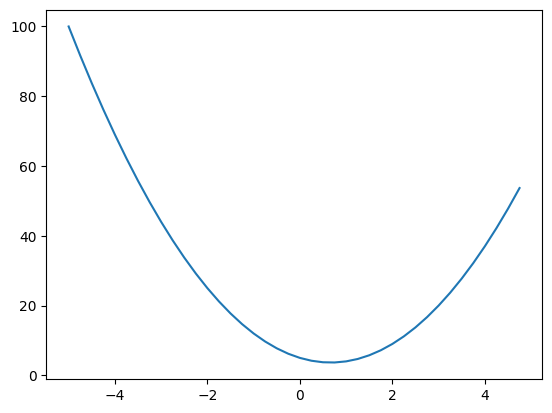

In [12]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [21]:
h = 0.01
x = 2/3
(f(x+h) - f(x))/h

0.02999999999997449

In [6]:
# A simple expression
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


Differentiating d wrt a will give b. And b is equal to -3. So our response is correct.

Class Value takes a single scalar value that it wraps and keep a track of.

As data is a numerical value, self.data + other.data is actually a floating point value summation and not a Value object summation.

In [125]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out
        
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            other.data = self.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
f = Value(-2.0, label = 'f')
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [72]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [126]:
# these are the inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron 
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

In [30]:
import math

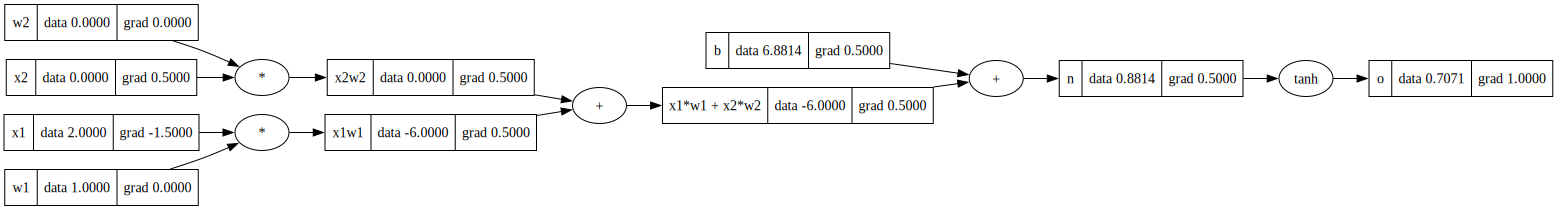

In [129]:
draw_dot(o)

In [128]:
o.backward()

In [119]:
x2w2._backward()

In [117]:
x1w1._backward()

In [115]:
x1w1x2w2._backward()

In [111]:
n._backward()

In [113]:
b._backward()

In [110]:
o._backward()

In [109]:
o.grad = 1.0

In [65]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [62]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [61]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [60]:
n.grad = 0.5

In [44]:
# o = tanh(n)
1 - o.data**2

0.4999999999999999

In [59]:
o.grad = 1.0